In [1]:
%matplotlib inline

# Geometric Median Composites for Landsat 7 Imagery  
  
This notebook is inspired by an IEEE publication titled [High-Dimensional Pixel Composites From
Earth Observation Time Series](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8004469) authored by Dale Roberts, Norman Mueller, and Alexis McIntyre.  
  
This notebook applies this compositing method to Landsat 7 imagery, displays a rendering of the computed composites, and saves them off to disk for further validation.  


# Loading the data  

> **Data cube object**  
> A datacube object is your interface with data stored on your data cube system.  
<br>  

In [2]:
import datacube
dc = datacube.Datacube()

> **Listing available products**  
> Lookup product/platform name to load in your data.
<br>  

In [3]:
product_listing = dc.list_products()
product_listing[product_listing["name"].str.contains('vietnam')]

,name,description,lat,time,instrument,lon,platform,product_type,format,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,
52,alos2_palsar_vietnam,ALOS2 PALSAR tile in DN format processed for t...,None,None,PALSAR,None,ALOS_2,gamma0,NetCDF,EPSG:4326,"[-0.0002666666667, 0.0002666666667]","[0.5333333334, 0.5333333334]","(latitude, longitude)"
55,alos_palsar_vietnam,ALOS PALSAR tile in DN format processed for th...,None,None,PALSAR,None,ALOS,gamma0,NetCDF,EPSG:4326,"[-0.0002666666667, 0.0002666666667]","[0.5333333334, 0.5333333334]","(latitude, longitude)"
31,ls7_ledaps_vietnam,Landsat 7 USGS Collection 1 Higher Level SR sc...,None,None,ETM,None,LANDSAT_7,LEDAPS,NetCDF,EPSG:4326,"[-0.000269494585236, 0.000269494585236]","[0.943231048326, 0.943231048326]","(latitude, longitude)"
34,ls8_lasrc_vietnam,Landsat 8 USGS Collection 1 Higher Level SR sc...,None,None,OLI_TIRS,None,LANDSAT_8,LaSRC,NetCDF,EPSG:4326,"[-0.000269494585236, 0.000269494585236]","[0.943231048326, 0.943231048326]","(latitude, longitude)"
60,s1_gamma0_vietnam,"Sentinel-1A/B SAR Gamma0, processed to the CEO...",None,None,SAR,None,SENTINEL_1,gamma0,NetCDF,EPSG:4326,"[-0.000269715032, 0.000269715032]","[0.809145096, 0.809145096]","(latitude, longitude)"


In [4]:
platform = 'LANDSAT_7'
product = 'ls7_ledaps_vietnam'

> **Select and visualize**  
> Select and visualize the region you'll be working with.  
<br>  

In [5]:
lat = (11.1285, 11.2072)
lon = (107.2200, 107.3241)

In [6]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = lat,longitude = lon)  

### Narrow down time range

In [7]:
from datetime import datetime 

date_range = ( datetime(2015,1,1), datetime(2015,12,24))

### Load product

In [8]:

landsat_dataset = dc.load(product = product,\
	platform = platform,\
	lat = lat,\
	lon = lon,\
	time = date_range,\
	measurements = ['red','green','nir','swir1', 'swir2','blue', 'pixel_qa'])


In [9]:
landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 292, longitude: 388, time: 18)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-09T03:06:13 2015-01-25T03:06:16 ...
  * latitude   (latitude) float64 11.21 11.21 11.21 11.21 11.21 11.21 11.21 ...
  * longitude  (longitude) float64 107.2 107.2 107.2 107.2 107.2 107.2 107.2 ...
Data variables:
    red        (time, latitude, longitude) int16 856 775 776 796 796 775 796 ...
    green      (time, latitude, longitude) int16 895 960 917 938 938 895 917 ...
    nir        (time, latitude, longitude) int16 1084 1130 1130 1084 1084 ...
    swir1      (time, latitude, longitude) int16 582 608 582 662 662 688 662 ...
    swir2      (time, latitude, longitude) int16 487 515 487 487 487 487 460 ...
    blue       (time, latitude, longitude) int16 932 890 890 953 953 932 911 ...
    pixel_qa   (time, latitude, longitude) int32 224 224 224 224 224 224 224 ...
Attributes:
    crs:      EPSG:4326

# Create a cloud mask  

In [10]:
from functools import reduce  
import numpy as np  

def ls7_qa_mask(dataset, keys):
    land_cover_endcoding = dict( fill     =  [1], 
                                 clear    =  [66,  130], 
                                 water    =  [68,  132],
                                 shadow   =  [72,  136],
                                 snow     =  [80,  112, 144, 176],
                                 cloud    =  [96,  112, 160, 176, 224],
                                 low_conf =  [66,  68,  72,  80,  96,  112],
                                 med_conf =  [130, 132, 136, 144, 160, 176],
                                 high_conf=  [224]
                               ) 
    def merge_lists(a, b): 
        return a.union(set(land_cover_endcoding[b]))
                        
    relevant_encodings = reduce(merge_lists, keys,set())
    return np.isin(dataset.pixel_qa.values, list(relevant_encodings)) 


In [11]:
clean_mask_np = ls7_qa_mask(landsat_dataset, ["clear", "water"])

# Geometric Median/Medoid Compositing

In [12]:
import hdmedians as hd
import xarray as xr  

def nan_to_num(dataset, number):
    for key in list(dataset.data_vars):
        dataset[key].values[np.isnan(dataset[key].values)] = number  
        
def create_hdmedians_multiple_band_mosaic(dataset_in,
                                          clean_mask=None,
                                          no_data=-9999,
                                          intermediate_product=None,
                                          operation="median",
                                          **kwargs):
        
    assert clean_mask is not None, "A boolean mask for clean_mask must be supplied."
    assert operation in ['median', 'medoid'], "Only median and medoid operations are supported."

    dataset_in_filtered = dataset_in.where((dataset_in != no_data) & (clean_mask))

    band_list = list(dataset_in_filtered.data_vars)
    arrays = [dataset_in_filtered[band] for band in band_list]

    stacked_data = np.stack(arrays)
    bands_shape, time_slices_shape, lat_shape, lon_shape = stacked_data.shape[0], stacked_data.shape[
        1], stacked_data.shape[2], stacked_data.shape[3]

    reshaped_stack = stacked_data.reshape(bands_shape, time_slices_shape,
                                          lat_shape * lon_shape)  # Reshape to remove lat/lon
    hdmedians_result = np.zeros((bands_shape, lat_shape * lon_shape))  # Build zeroes array across time slices.

    for x in range(reshaped_stack.shape[2]):
        try:
            hdmedians_result[:, x] = hd.nangeomedian(
                reshaped_stack[:, :, x], axis=1) if operation == "median" else hd.nanmedoid(
                    reshaped_stack[:, :, x], axis=1)
        except ValueError:
            no_data_pixel_stack = reshaped_stack[:, :, x]
            no_data_pixel_stack[np.isnan(no_data_pixel_stack)] = no_data
            hdmedians_result[:, x] = np.full((bands_shape), no_data) if operation == "median" else hd.nanmedoid(
                no_data_pixel_stack, axis=1)

    output_dict = {
        value: (('latitude', 'longitude'), hdmedians_result[index, :].reshape(lat_shape, lon_shape))
        for index, value in enumerate(band_list)
    }

    dataset_out = xr.Dataset(output_dict,
                             coords={'latitude': dataset_in['latitude'], 'longitude': dataset_in['longitude']},
                             attrs = dataset_in.attrs)
    nan_to_num(dataset_out, no_data)
    return dataset_out

----   

# Medoid   

> ### Geometric  Medoid Compositing   
> To compute a Geo-Medoid composite , the geometric medoid algorithm is applied to the time series of every pixel (indexed by `lat,lon`).  
Every pixel( indexed by `time,lat,lon`) in the the time series is treated as an independent observation used in the computation of the geometric medoid.  
  
> In the case of Landsat7 imagery an observation `<red,green,blue,nir,swir1,swir2>` is a vector/point embedded in 6-dimensional feature-space. 

>  
> 

> ### Formal Definition of a  Geometric Medoid  
>Given a finite set $\mathbb{X}$ of $\mathbb{_p}$-dimensional observation vectors $\mathbb{X} = \{x_1,...,x_n \}$ , the medoid  of these observations is given by the following equation <sup>[[1]](#hd_medians)</sup>: 
  
>$$ m := argmin_{ x \in \mathbb{X}} \sum_{i=1}^{n}{ \lVert x - x_i\rVert }   $$
  


### Run Medoid compositor    

In [13]:
medoid_mosaic = create_hdmedians_multiple_band_mosaic( landsat_dataset,
                                                       clean_mask = clean_mask_np,
                                                       operation = 'medoid')

> ### Example of a composited `swir1` band

In [14]:
def figure_ratio(ds, fixed_width = 20):
    width = fixed_width
    height = len(ds.latitude) * (fixed_width / len(ds.longitude))
    return (width, height)

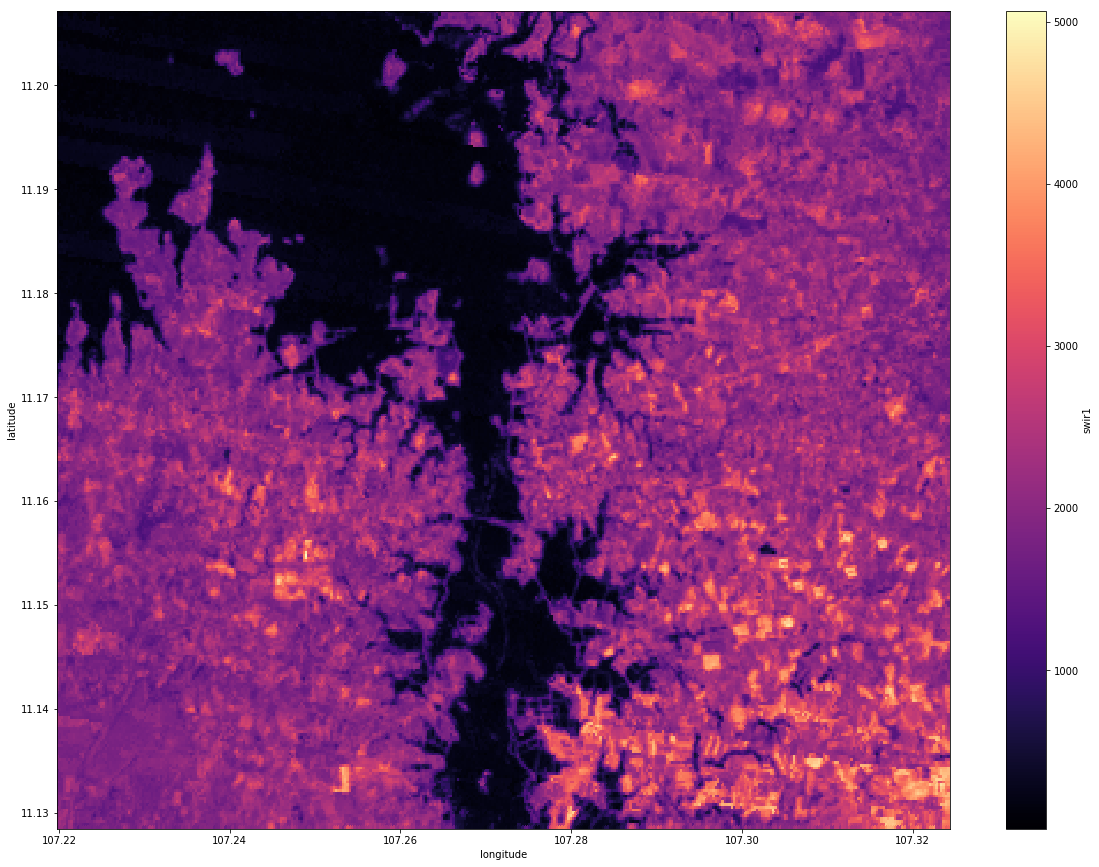

In [15]:
medoid_mosaic.swir1.plot(figsize = figure_ratio(landsat_dataset), cmap = 'magma')

----  

# Median   

> ### Geometric  Median Compositing   
> To compute a Geo-Median composite , the geometric Median algorithm is applied to the time series of every pixel (indexed by `lat,lon`).  
Every pixel( indexed by `time,lat,lon`) in the the time series is treated as an independent observation used in the computation of the geometric Median.  
  
> In the case of Landsat7 imagery an observation `<red,green,blue,nir,swir1,swir2>` is a vector/point embedded in 6-dimensional feature-space. 

>  
> 

> ### Formal Definition of a  Geometric Median  
>Given a finite set $\mathbb{X}$ of $\mathbb{_p}$-dimensional observation vectors $\mathbb{X} = \{ x_1,...,x_n \}$ , the Median  of these observations is given by the following equation <sup>[[1]](#hd_medians)</sup>: 
  
>$$ \hat{\mu} := argmin_{ x \in \mathbb{R^{_p}}} \sum_{i=1}^{n}{ \lVert x - x_i\rVert }   $$
  
> **Note:**  
> there is a subtle difference between the definition of the geometric median and the medoid: the search space for the solution differs and has the effect that the medoid returns one of the true observations whereas the geometric median can be described as a synthetic (not physically observed) observation.<sup>[[1]](#hd_medians)</sup> 


In [16]:
median_mosaic = create_hdmedians_multiple_band_mosaic(landsat_dataset,
                                               clean_mask = clean_mask_np,
                                               operation = 'median')

> ### Example of a composited `swir1` band

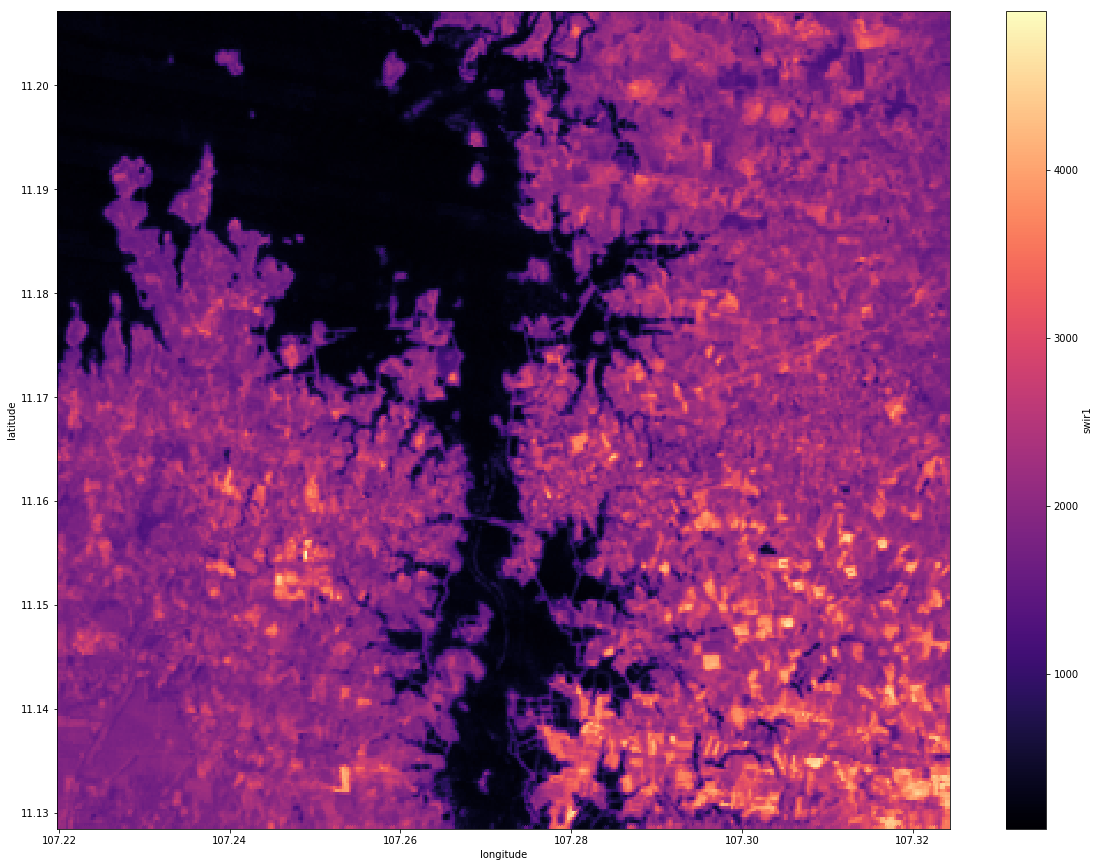

In [17]:
median_mosaic.swir1.plot(figsize = figure_ratio(landsat_dataset), cmap = 'magma')

# Write both composites to file   
You may want to explore these files in with QGIS

>### PNG  

In [18]:
from utils.data_cube_utilities.dc_utilities import write_png_from_xr
write_png_from_xr('pngs/geo_median.png', median_mosaic, ['red','green','blue'], scale=(0,4000))
write_png_from_xr('pngs/geo_medoid.png', medoid_mosaic, ['red','green','blue'], scale=(0,4000))

>### NetCDF

In [20]:
datacube.storage.storage.write_dataset_to_netcdf(median_mosaic, 'netcdfs/geo_medians_ls7_01.nc')
datacube.storage.storage.write_dataset_to_netcdf(medoid_mosaic, 'netcdfs/geo_medoids_ls7_01.nc')

>### GeoTiff

In [21]:
from utils.data_cube_utilities import dc_utilities
def export_slice_to_geotiff(ds, path):
    dc_utilities.write_geotiff_from_xr(path,
                                        ds.astype(np.float32),
                                        list(ds.data_vars.keys()),
                                        crs="EPSG:4326")

In [22]:
export_slice_to_geotiff(median_mosaic, 'geotiffs/geo_medians_ls7.tif')
export_slice_to_geotiff(medoid_mosaic, 'geotiffs/geo_medoids_ls7.tif')

In [ ]:
!ls -lah geotiffs/geo*.tif

----   
# References   

<span id='hd_medians'></span>  
1. Dale Roberts 2018. Hdmedians. Github: https://github.com/daleroberts/hdmedians,  
  
2. Small, C. G. (1990). A survey of multidimensional medians. International Statistical Review/Revue Internationale de Statistique, 263-277.
